In [31]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import BallTree
import copy
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.figure_factory as ff
import geopandas as gpd
from shapely.geometry import Point, Polygon
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

In [18]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [19]:
folder = "../00_Raw_Data/"

# Generate filenames from 2015_Q1 to 2022_Q4
years = range(2015, 2023)
quarters = range(1, 5)

files = ["{}_Q{}_Traffic_Crashes.csv".format(year, quarter) for year in years for quarter in quarters]

dfs = [pd.read_csv(folder + file) for file in files]
df = pd.concat(dfs, ignore_index=True)
df = df[(df['longitude'] >= -87.05) & (df['longitude'] <= -86.5) & (df['latitude'] >= 35.96) & (df['latitude'] <= 36.395)]

In [20]:
df['collision_date'] = pd.to_datetime(df['collision_date'], format='%m/%d/%Y %I:%M:%S %p')
df['date'] = df['collision_date'].dt.date

df['day_of_week'] = df['collision_date'].dt.dayofweek # 0: Monday - 6: Sunday

df['time'] = df['collision_date'].dt.time
df['hour'] = df['collision_date'].dt.hour
df['month'] = df['collision_date'].dt.month
df['year'] = df['collision_date'].dt.year
df['covid'] = (df['date'] >= pd.Timestamp('2020-03-15').date()).astype(int)

columns_to_convert = ['pedestrian', 'bicycle', 'scooter', 'hitrun', 'parking']

for column in columns_to_convert:
    df[column] = df[column].map({'yes': 1, 'no': 0})
    
df['manner_of_crash'] = df['manner_of_crash'].fillna('Unknown/Missing')
df['manner_of_crash'] = df['manner_of_crash'].replace(['Missing', 'Unknown'], 'Unknown/Missing')
encoder = LabelEncoder()

df['manner_of_crash'] = encoder.fit_transform(df['manner_of_crash'])

df['roadway_name'] = df['roadway_name'].fillna('UNKNOWN')
df['roadway_name'] = df['roadway_name'].replace(['UNNAMED ROAD', 'UNNAMED STREET', '-- UNKNOWN RAMP/ROAD --'], 'UNKNOWN')
roadway_encoder = LabelEncoder()
df['roadway_name'] = roadway_encoder.fit_transform(df['roadway_name'])

df['intersection_indicator'] = df['intersection_indicator'].fillna("N")
df['intersection_indicator'].replace("Missing", "N", inplace=True)
mapping = {"N": 0, "Y": 1}
df['intersection_indicator'] = df['intersection_indicator'].map(mapping)
df['intersection_indicator'] = df['intersection_indicator'].astype('int64')

df['intersect_type'] = df['intersect_type'].fillna('Unknown/Other')
df['intersect_type'].replace(['OTHER', 'Missing', 'Unknown'], 'Unknown/Other', inplace=True)
intersect_type_encoder = LabelEncoder()
df['intersect_type'] = intersect_type_encoder.fit_transform(df['intersect_type'])

df['relation_to_junction'] = df['relation_to_junction'].fillna('Unknown/Other')
df['relation_to_junction'].replace(['Missing', 'OtherLocation', 'Unknown'], 'Unknown/Other', inplace=True)
relation_to_junction_encoder = LabelEncoder()
df['relation_to_junction'] = relation_to_junction_encoder.fit_transform(df['relation_to_junction'])

df['mou'] = df['mou'].replace('OHO', 'Campus')
df['mou'] = df['mou'].apply(lambda x: 1 if x == 'Campus' else 0)


df['work_zone_type'] = df['work_zone_type'].fillna('Missing')
df['work_zone_type'] = df['work_zone_type'].apply(lambda x: 0 if x == "Missing" or x == "Unknown" else 1)

def simplify_weather(weather):
    if pd.isna(weather):
        return 'Unknown/Other'
    elif 'Snow' in weather:
        return 'Snow'
    elif 'Sleet/Hail' in weather:
        return 'Sleet/Hail'
    elif 'Rain' in weather:
        return 'Rain'
    elif weather in ['Fog', 'Smoke', 'Smog']:
        return 'Fog'
    elif 'Cloudy' in weather:
        return 'Cloudy'
    elif weather == 'Clear':
        return 'Clear'
    elif weather in ['Missing', 'Unknown', 'Other']:
        return 'Unknown/Other'
    else:
        return 'Other Conditions'

df['weather_condition(s)'] = df['weather_condition(s)'].apply(simplify_weather)
simplified_weather_encoder = LabelEncoder()
df['weather_condition(s)'] = simplified_weather_encoder.fit_transform(df['weather_condition(s)'])

df['city'] = df['city'].fillna('Unknown')
city_encoder = LabelEncoder()
df['city'] = city_encoder.fit_transform(df['city'])

def bool_to_int(df):
    for col in df.select_dtypes(['bool']).columns:
        df[col] = df[col].astype(int)
    return df

df = bool_to_int(df)

def categorize_time_window(hour):
    if 6 <= hour <= 9:
        return 'rush_morning'
    elif 15 <= hour <= 18:
        return 'rush_evening'
    elif 10 <= hour <= 14:
        return 'non_rush_day'
    else:  
        return 'non_rush_night'

df['time_window'] = df['hour'].apply(categorize_time_window)


df['time'] = df['time'].astype(str)
df['time'] = df['time'].str.strip()
has_time_df = df[df['time'] != "00:00:00"]

weekday_df = has_time_df[has_time_df['day_of_week'].between(0, 4)].copy()  

weekday_df = weekday_df.sample(frac=1, random_state=42).reset_index(drop=True)

time_window_mapping = {
    'rush_morning': 0,
    'rush_evening': 1,
    'non_rush_day': 2,
    'non_rush_night': 3
}

weekday_df['time_window'] = weekday_df['time_window'].replace(time_window_mapping)

In [21]:
columns_to_drop = [
    "agency", "agency_tracking_number", "county",
    "collision_date", "roadway_suffix", "roadway_number", "roadway_local_id",
    "distance_from_reference", "miles-feet_indicator", "direction_from_reference",
    "intersection_road_name", "intersection_road_name_suffix", "intersection_road_number",
    "intersection_local_id", "mile_marker", "interchange_related_indicator",
    "construction_maintenance_zone", "construction_maintenance_zone_location",
    "fatal_case_number", "officer_first_name", "officer_last_name", "date", "time", "hour"
]

weekday_df = weekday_df.drop(columns=columns_to_drop, axis=1)

In [22]:
has_time_df = copy.deepcopy(weekday_df)

train, test = train_test_split(has_time_df, test_size=0.3, stratify=has_time_df['time_window'], random_state=42)

In [23]:
def unique_values_count(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """Return unique values, their counts, and the count of missing values for a given DataFrame column."""
    
    counts = df[column].value_counts(dropna=False).reset_index()
    counts.columns = [column, 'Count']
    
    counts[column] = counts[column].fillna('Missing')
    
    return counts

In [24]:
unique_values_count(train, 'time_window')

,time_window,Count
0,1,47820
1,2,38252
2,0,30394
3,3,26445


## Mode Imputation

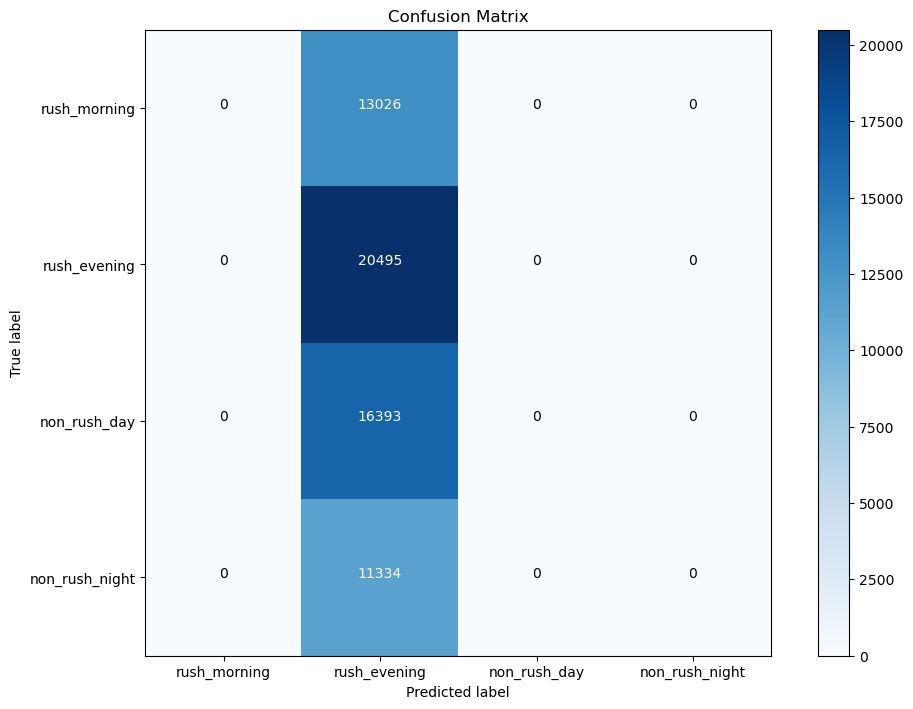

Class-wise Metrics:
rush_morning - Precision: 0.00, Recall: 0.00, F1-Score: 0.00
rush_evening - Precision: 0.33, Recall: 1.00, F1-Score: 0.50
non_rush_day - Precision: 0.00, Recall: 0.00, F1-Score: 0.00
non_rush_night - Precision: 0.00, Recall: 0.00, F1-Score: 0.00

Macro Averages:
Precision: 0.08, Recall: 0.25, F1-Score: 0.13

Micro Averages:
Precision: 0.33, Recall: 0.33, F1-Score: 0.33

Accuracy: 0.33


/home/jiax1/.conda/envs/finalproj/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jiax1/.conda/envs/finalproj/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
mode_time_window = train['time_window'].mode()[0]
test['imputed_time_window'] = mode_time_window

y_true = test['time_window'] 
y_pred = test['imputed_time_window']

cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
class_names = ['rush_morning', 'rush_evening', 'non_rush_day', 'non_rush_night']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Calculate precision, recall, f1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

print("Class-wise Metrics:")
for i, class_name in enumerate(class_names):
    print(f"{class_name} - Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1-Score: {f1_score[i]:.2f}")

# Calculate macro and micro averages
precision_macro, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')

print("\nMacro Averages:")
print(f"Precision: {precision_macro:.2f}, Recall: {recall_macro:.2f}, F1-Score: {f1_score_macro:.2f}")

print("\nMicro Averages:")
print(f"Precision: {precision_micro:.2f}, Recall: {recall_micro:.2f}, F1-Score: {f1_score_micro:.2f}")

# Finally, print out the accuracy as well
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

### Weighted Random Guess Imputation

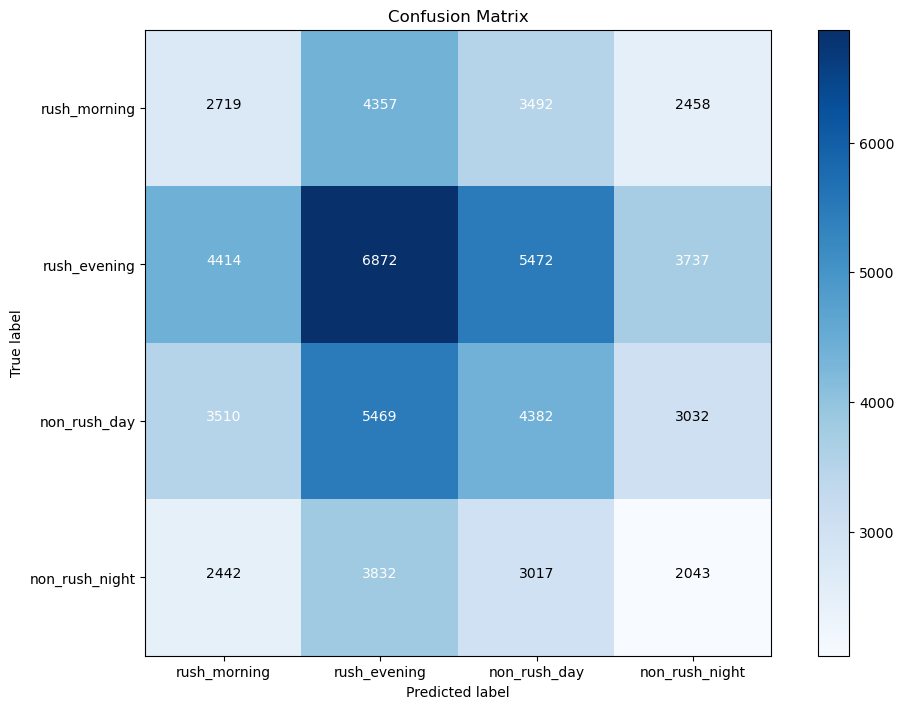

Class-wise Metrics:
rush_morning - Precision: 0.21, Recall: 0.21, F1-Score: 0.21
rush_evening - Precision: 0.33, Recall: 0.34, F1-Score: 0.34
non_rush_day - Precision: 0.27, Recall: 0.27, F1-Score: 0.27
non_rush_night - Precision: 0.18, Recall: 0.18, F1-Score: 0.18

Macro Averages:
Precision: 0.25, Recall: 0.25, F1-Score: 0.25

Micro Averages:
Precision: 0.26, Recall: 0.26, F1-Score: 0.26

Accuracy: 0.26


In [46]:
np.random.seed(42)  

value_counts = train['time_window'].value_counts(normalize=True)

unique_values = value_counts.index.tolist()
weights = value_counts.values.tolist()

test['weighted_random_guess_time_window'] = np.random.choice(unique_values, size=len(test), p=weights)

y_true = test['time_window'] 
y_pred = test['weighted_random_guess_time_window']

cm = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
class_names = ['rush_morning', 'rush_evening', 'non_rush_day', 'non_rush_night']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Calculate precision, recall, f1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

print("Class-wise Metrics:")
for i, class_name in enumerate(class_names):
    print(f"{class_name} - Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1-Score: {f1_score[i]:.2f}")

# Calculate macro and micro averages
precision_macro, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
precision_micro, recall_micro, f1_score_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')

print("\nMacro Averages:")
print(f"Precision: {precision_macro:.2f}, Recall: {recall_macro:.2f}, F1-Score: {f1_score_macro:.2f}")

print("\nMicro Averages:")
print(f"Precision: {precision_micro:.2f}, Recall: {recall_micro:.2f}, F1-Score: {f1_score_micro:.2f}")

# Finally, print out the accuracy as well
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")